In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)
from datetime import datetime

In [2]:
df= pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df[['group','landing_page']]=df[['group','landing_page']].astype('category')

In [5]:
df['timestamp']=df['timestamp'].astype('datetime64')

In [6]:
df.isna().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

In [7]:
df.duplicated().any()

False

In [8]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [9]:
df['converted'].mean()

0.11965919355605512

In [10]:
cn=df.query("group=='control' and landing_page =='new_page'")
to=df.query("group=='treatment' and landing_page =='old_page'")
cn.shape[0]+to.shape[0]

3893

In [11]:
## how long has it been run
df['timestamp'].max()-df['timestamp'].min()

Timedelta('21 days 23:59:49.081927')

In [12]:
df2=df.drop(cn.append(to).index)

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null datetime64[ns]
group           290585 non-null category
landing_page    290585 non-null category
converted       290585 non-null int64
dtypes: category(2), datetime64[ns](1), int64(2)
memory usage: 9.4 MB


In [14]:
df2['landing_page'].value_counts()

new_page    145311
old_page    145274
Name: landing_page, dtype: int64

In [15]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

In [16]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [17]:
df2.query("user_id==773192")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [18]:
df2.drop(index=1899, inplace=True)

In [19]:
df2.nunique()

user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
dtype: int64

In [20]:
df2['converted'].mean()

0.11959708724499628

In [21]:
df2.groupby(['group'])['converted'].mean()

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

In [22]:
ogdiff=df2.groupby(['group'])['converted'].mean()[1]-df2.groupby(['group'])['converted'].mean()[0]
ogdiff

-0.0015782389853555567

In [23]:
df2.query("landing_page =='new_page'").shape[0]/df2.shape[0]

0.5000619442226688

giving everything else been equal, treatment group have the alomst the same conversion rate as control if not less

convert rate for both control and treatment are the same under $H_{0}$ which is 

In [24]:
crate=df2['converted'].mean()
crate

0.11959708724499628

/# of samples in control and treatment group are same the as df2

In [25]:
df2.groupby(['group'])['user_id'].count()

group
control      145274
treatment    145310
Name: user_id, dtype: int64

In [26]:
nnew=df2.groupby(['group'])['user_id'].count()[1]
nold=df2.groupby(['group'])['user_id'].count()[0]
nnew

145310

In [27]:
### random sample for each group
oldmean=np.random.binomial(nold,crate,10000)/nold
newmean=np.random.binomial(nnew,crate,10000)/nnew
p_diffs= newmean-oldmean
p_diffs

array([-7.09576826e-05, -1.88095633e-03,  4.72864479e-04, ...,
       -2.92732667e-03,  1.43632533e-03, -3.39539574e-03])

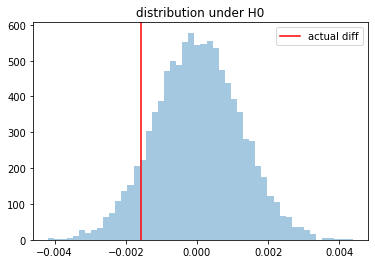

In [28]:
sns.distplot(p_diffs, kde=False)
plt.axvline(ogdiff, color='r',label='actual diff')
plt.title('distribution under H0')
plt.legend(loc=0);

In [29]:
# giving H0 is ture, the probability of getting Ha> H0 is 90.9%
(p_diffs>ogdiff).mean()

0.9081

In [30]:
# two tails means p-value of Ha!= H0 is 18.48%
lower= (p_diffs<ogdiff).mean()
upper= (p_diffs>abs(ogdiff)).mean()
lower+upper

0.1883

# statsmodels obtain A/B test result

In [31]:
import statsmodels.api as sm

control= df2.query("group == 'control'")
treat=df2.query("group == 'treatment'")
controlsucceed=control['converted'].sum()
treatsucceed=treat['converted'].sum()
print('control succeed:{}, treatment succeed:{}. control total:{}, treamment total:{}'.format(controlsucceed,
                                           treatsucceed, nold,nnew))

control succeed:17489, treatment succeed:17264. control total:145274, treamment total:145310


In [32]:
z_socre,p_value=sm.stats.proportions_ztest([controlsucceed,treatsucceed],
                                           [nold,nnew],alternative='smaller')
print(z_socre,p_value)

1.3109241984234394 0.9050583127590245


# logistic regression obtain A/B test result

Add an intercept column, as well as an ab_page column, which is 1 when an individual receives the treatment and 0 if control.

In [33]:
df2['intercept']=1
pd.get_dummies(df2['group'])

group,control,treatment
0,1,0
1,1,0
2,0,1
3,0,1
4,1,0
...,...,...
294473,1,0
294474,1,0
294475,1,0
294476,1,0


In [34]:
df2['treatgroup']=pd.get_dummies(df2['group'])['treatment']

In [35]:
model =sm.Logit(df2['converted'],df2[['intercept','treatgroup']])
model.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 Apr 2020   Pseudo R-squ.:               8.077e-06
Time:                        21:57:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatgroup    -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

with eveything else staying the same, treatment group is 1.02 times less likely result conversion(neglectable).

In [36]:
1/np.exp(-0.0150)

1.015113064615719

# ADD CITY VARIABLE

In [37]:
citydf =pd.read_csv('countries.csv')
citydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [40]:
df_new=df2.merge(citydf,on='user_id')

In [53]:
usdf=df_new.query("country=='US'")
usdf

,user_id,timestamp,group,landing_page,converted,intercept,treatgroup,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US
...,...,...,...,...,...,...,...,...
290577,718310,2017-01-21 22:44:20.378320,control,old_page,0,1,0,US
290579,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,US
290580,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,US
290581,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,US


In [68]:
## totals
uscontrol=usdf.query('group =="control"')
ustreatment=usdf.query('group =="treatment"')
uscontrol.shape[0]

101716

In [69]:
## succeeds
uscontrolsuccess=uscontrol['converted'].sum()
ustreatmentsuccess=ustreatment['converted'].sum()
uscontrolsuccess

12270

In [70]:
## fit model
z_score,p_value=sm.stats.proportions_ztest([uscontrolsuccess,ustreatmentsuccess],
[uscontrol.shape[0],ustreatment.shape[0]],alternative='smaller')

P-value of treatment converted rate > control converted rate under $H_{0}$ is 0.9338628264991603

In [71]:
print(z_score,p_value)

1.5051934564639167 0.9338628264991603


In [84]:
df_new=df_new.join(pd.get_dummies(df_new['country']))

In [87]:
df_new

,user_id,timestamp,group,landing_page,converted,intercept,treatgroup,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
290579,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,US,0,0,1
290580,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,US,0,0,1
290581,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,US,0,0,1
290582,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0,US,0,0,1


In [90]:
result=sm.Logit(df_new['converted'],df_new[['intercept','UK','US']]).fit().summary()
result

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 06 Apr 2020   Pseudo R-squ.:               1.521e-05
Time:                        23:51:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [96]:
## UK/US is 1.05/1.04 times more likely to conver than CA
np.exp(0.0507),np.exp(0.0408)

(1.052007243765014, 1.0416437559600236)

In [98]:
sm.Logit(df_new['converted'],df_new[['intercept','treatgroup','US','UK']]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 06 Apr 2020   Pseudo R-squ.:               2.323e-05
Time:                        23:56:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
treatgroup    -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [99]:
# treatgroup is 1.05 times less likely than control gruop to result conversion
1/np.exp(-0.0149)

1.0150115583846535

## Getting hours

In [112]:
df_new['morning']=df_new['timestamp'].dt.hour

In [113]:
def converttime(i):
    if i <12:
        i=1
    else:
        i=0
    return i

In [115]:
df_new['morning']= df_new['morning'].apply(converttime)

In [116]:
df_new

,user_id,timestamp,group,landing_page,converted,intercept,treatgroup,country,CA,UK,US,hour,morning
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,22,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,8,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,16,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,18,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
290579,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,US,0,0,1,22,0
290580,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,US,0,0,1,0,1
290581,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,US,0,0,1,11,1
290582,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0,US,0,0,1,1,1


### logistic regression

In [122]:
model=sm.Logit(df_new['converted'],df_new[['intercept','treatgroup','US','UK','morning']])
refult=model.fit().summary()
refult

Optimization terminated successfully.
         Current function value: 0.366106
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Tue, 07 Apr 2020   Pseudo R-squ.:               4.307e-05
Time:                        00:29:22   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.05713
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0182      0.027    -74.095      0.000      -2.072      -1.965
treatgroup    -0.0150      0.011     -1.310      0.190      -0.037       0.007
US             0.0406      0.027      1.509      0.131      -0.012       0.093
UK             0.0505      0.028      1.779      0.075      -0.005       0.106
morning       -0.0235      0.011     -2.054      0.040      -0.046      -0.001
==============================================================================
"""

In [121]:
## everything else been same, 
#evening is 1.02 times more likely to have convert
## p-value suggest it is highly correlated
1/np.exp(-0.0235)

1.0237783007466292

### statsmodels

In [127]:
## succeeds
morningsucceed=df_new.query("morning==1")['converted'].sum()
eveningsucceed=df_new.query("morning==0")['converted'].sum()

17184

In [132]:
# totals
morningtotal=df_new.query("morning==1").shape[0]
eveningtotal=df_new.query("morning==0").shape[0]
morningtotal,eveningtotal

(145186, 145398)

In [135]:
z_score,p_value=sm.stats.proportions_ztest([morningsucceed,eveningsucceed],
[morningtotal,eveningtotal],alternative='smaller')

In [136]:
## strong evdience to reject H0
print(z_score,p_value)

-2.0560693594525903 0.019887915582356346


### plot

In [139]:
morningmean=df_new.query("morning==1")['converted'].mean()
eveniungmean=df_new.query("morning==0")['converted'].mean()

In [152]:
morningrate=np.random.binomial(morningtotal,crate,10000)/morningtotal
eveningrate=np.random.binomial(eveningtotal,crate,10000)/eveningtotal

In [153]:
plotdiff=eveningrate-morningrate

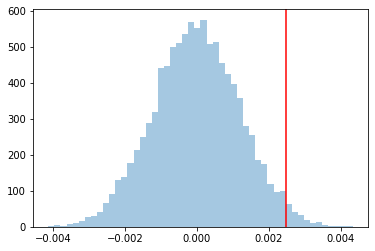

In [154]:
sns.distplot(plotdiff,kde=False)
plt.axvline(eveniungmean-morningmean,color='r');

In [156]:
(plotdiff>(eveniungmean-morningmean)).mean()

0.0193